In [50]:
import pandas as pd
import numpy as np
import pygeostat as gs # pip install pygeostat
from matplotlib import pyplot as plt

Loading default Pygeostat Parameters from C:\Users\MostafaHadavand\.Pygeostat\Parameters.json


# Least Square Regression

The linear regression is referred to as multiple linear regression when the number of predictors is more than one. The equation is the same as the response is a linear combination of multiple response variables plus a bias term. Consider the following example where the response variable $y$ is predicted by $d$ predictors. 

$ y^* = w_1.X_1 + w_2.X_1 + ... w_d.X_d) + b $

where $y*$ is the prediction of the response variable $y$. The matrix form would be:

$ \pmb{y*} = \pmb{X} . \pmb{w} + b$ 

where $\pmb{X}$ is $1 \times d$ and $\pmb{w}$ is $d\times 1$. Interesting enough this is similar to a MLP neural network without the activation. Each observation of $X$ can be mapped to a corresponding prediction $y$.In this context, considering all observations, $\pmb{X}$ is $n \times d$ and $\pmb{w}$ is $d\times 1$ and $n$ is the number of observations.

The loss function is given by:

$L(w,b) = \sum (y^{i} - y^{*i})^2 = \sum (y^{i} - (X^{i}.w+b))^2 \;\; i=1,..n$

where $n$ is the total number of observations. In order to make this simpler, a 1 is added to each $X$ vector (i.e. each observation). 

$ X^{i} =  [1, X^i_1, ... X^i_d] \;\;\; i=1,..n$

then, the bias is added to the weight matrix

$ \tilde{w} = [b, w_1, ..., w_d]$ 

$L(\pmb{w},b) =  \sum (y^{i} - (\pmb{X}^{i}.\pmb{w}+b))^2 \;\; i=1,..n$

The solution for the weights and bias is 

$\tilde{w} = (X^T X)^{-1} (X^TY) $

Solving the equation above, provides the $d$ weights and the bias value. The bias is calculated to be:

$ b = m_y - \sum w^j m_x^j \;\;\; j=1,..,d $

where $m_y$ and $m_x^j$ are the mean/expected values of the response and predictor variables respectively.

The unbiasedness condition $E\{y\} = E\{y*\}$ would result to the same biased value. In other words, we could use residuals and ignore the bias term. This is the way it is done in simple kriging that is a linear regression method in spatial statistics.

Note that the loss function is defined as the least squared error and the optimization is based on minimizing the expected/aggregated squared error for all the training data sets. This is referred to as regular regression.

# Example

In [2]:
boston_data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv')
boston_data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Create a class to implement multiple linear regression

In [19]:
class mlr(object):
    
    '''
    A simple implementation of multiple linear regression
    
    X: array of n by d where n is the number of observation and d is the number of dimensions/features
    Y: array of n by 1 where n is the number of observation
    '''
    
    
    def __init__(self):
        self.weights = []
        
        
    def fit(self, X, y):
        
        if len(X.shape) == 1:
            X = self._reshape_x(X)
            
        X = self._concatenate_ones(X)
        self.weights = np.linalg.inv(X.transpose().dot(X)).dot(X.transpose().dot(y))
        
    def predict(self, feature_set):
        b = self.weights[0]
        w = self.weights[1:]
        
        prediction = feature_set.dot(w) + b
        
        return prediction
    
    def _reshape_x(self, X):
        return X.reshape(-1,1)
    
    def _concatenate_ones(self,X):
        ones = np.ones(shape=X.shape[0]).reshape(-1,1)
        return np.concatenate((ones,X), 1)

## Use the example data and make predictions

In [20]:
X = boston_data.drop('medv', axis=1).values
y = boston_data['medv'].values

In [26]:
model = mlr() 
model.fit(X,y)

In [27]:
model.weights

array([ 3.64594884e+01, -1.08011358e-01,  4.64204584e-02,  2.05586264e-02,
        2.68673382e+00, -1.77666112e+01,  3.80986521e+00,  6.92224640e-04,
       -1.47556685e+00,  3.06049479e-01, -1.23345939e-02, -9.52747232e-01,
        9.31168327e-03, -5.24758378e-01])

In [41]:
boston_data['predicted_medv'] = boston_data[list(boston_data.columns)[:-1]].apply(lambda x: model.predict(x), axis=1)

In [46]:
boston_data['SquaredError'] = boston_data[['medv','predicted_medv']].apply(lambda x: (x[0] - x[1])**2, axis=1)

In [48]:
boston_data['SquaredError'].mean()

21.894831181729206

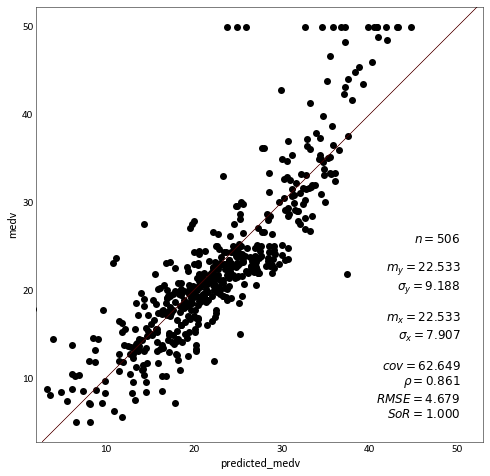

In [52]:
_ = gs.validation_plot(boston_data['predicted_medv'], boston_data['medv'])

# Regularization

Regularization is based on adding a penalty term to the least squared loss function to penalize effect of weights. In other words, the contribution of training data gets regularized to reduce the emphasis on training data. This results in more generalization and avoid over fitting training data and likely to improve test accuracy. 

$L(w,b) = \sum (y^{i} - y^{*i})^2 = \sum (y^{i} - (X^{i}.w+b))^2 + \lambda ||W||^p \;\; i=1,..n$

where $||W||^p$ is the $p$ norm. In this regard, if $\lambda$ is 0, it is equivalent to least square while very large $\lambda$ results in weights converging to zero which is a good solution when number of the training data sets are very low. The optimal value of $\lambda$ may be determined by cross validation and boot strap sampling of the data set.

The optimal solution for the weights is given by

$ w = (X^T X + \lambda I)^{-1} (X^T Y) $


**Ridge regression**

$L(w,b) = \sum (y^{i} - y^{*i})^2 = \sum (y^{i} - (X^{i}.w+b))^2 + \lambda ||W||^2 \;\; i=1,..n$


**Lasso regression**

Tends to produce sparse $w$ which means excluding certain features as certain elements of the weight vector become zero.

$L(w,b) = \sum (y^{i} - y^{*i})^2 = \sum (y^{i} - (X^{i}.w+b))^2 + \lambda ||W||^1 \;\; i=1,..n$